# Word2Vec Training & Evaluation on Alice’s Adventures in Wonderland

This project implements a custom Word2Vec model trained specifically on Lewis Carroll's "Alice's Adventures in Wonderland" to understand how neural word embeddings capture semantic relationships in literary text.


### What This Code Actually Does

I have built a complete Word2Vec training pipeline that:

- **Loads and preprocesses** the Alice in Wonderland text
- **Trains a neural network** to learn word relationships from the book
- **Evaluates the model's performance** on understanding word similarities and analogies
- **Visualizes the learned word relationships** to see how characters and concepts cluster together

The model learns to represent each word as a vector of numbers, where words with similar meanings (like "alice" and "girl") end up having similar vector representations.

In [1]:
!pip install gensim


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
ROOT = "/content/drive/MyDrive/DAM202"
import os
os.chdir(ROOT)

In [54]:
os.listdir()

['text.txt', 'my_word2vec_model.model', 'improved_word2vec_model.model']

### Data Collection and Preparation

In [ ]:
open("text.txt", "w", encoding="utf-8").close()

In [55]:
with open('text.txt', 'r', encoding='utf-8') as f: # Remember your data set path should be specified if not in same working directory
    texts = f.readlines()

- Loads the raw text file (Alice’s Adventures in Wonderland).

- Splits into lines for further processing.

In [ ]:
texts[:10]

["\ufeffALICE'S ADVENTURES IN WONDERLAND\n",
 '\n',
 '\n',
 '                          Lewis Carroll\n',
 '\n',
 '\n',
 '               THE MILLENNIUM FULCRUM EDITION 3.0\n',
 '\n',
 '\n',
 '\n']

# IMPORT LIBRARIES

In [229]:
import os
import re
import time
import string
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy.stats import spearmanr
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
import multiprocessing
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from gensim.models import Word2Vec

**Data Quality Assessment**


This function checks the quality of text data before training Word2Vec. It counts how many documents and words there are, measures sentence lengths, finds the most common words, and calculates quality scores like vocabulary diversity, word frequency, and rare word ratio. Basically, it tells me if my text data is rich, balanced, or too repetitive.

In [101]:
def assess_data_quality(texts):
    """Analyze text data quality for Word2Vec training"""

    stats = {
        'total_documents': len(texts),
        'total_words': 0,
        'unique_words': set(),
        'sentence_lengths': [],
        'word_frequencies': {}
    }

    for text in texts:
        words = text.lower().split()
        stats['total_words'] += len(words)
        stats['sentence_lengths'].append(len(words))
        stats['unique_words'].update(words)

        for word in words:
            stats['word_frequencies'][word] = stats['word_frequencies'].get(word, 0) + 1

    stats['vocabulary_size'] = len(stats['unique_words'])
    stats['avg_sentence_length'] = sum(stats['sentence_lengths']) / len(stats['sentence_lengths'])

    # Find most common words
    sorted_words = sorted(stats['word_frequencies'].items(), key=lambda x: x[1], reverse=True)
    stats['top_words'] = sorted_words[:20]

    # Quality indicators
    stats['quality_score'] = {
        'vocabulary_diversity': stats['vocabulary_size'] / stats['total_words'],
        'avg_word_frequency': stats['total_words'] / stats['vocabulary_size'],
        'rare_words_ratio': sum(1 for count in stats['word_frequencies'].values() if count == 1) / stats['vocabulary_size']
    }

    return stats

# Example usage
quality_report = assess_data_quality(texts)
print(f"Total documents: {quality_report['total_documents']:,}")
print(f"Vocabulary size: {quality_report['vocabulary_size']:,}")
print(f"Unique Words: {quality_report['unique_words']}")
print(f"Average sentence length: {quality_report['avg_sentence_length']:.1f}")
print(f"Vocabulary diversity: {quality_report['quality_score']['vocabulary_diversity']:.4f}")

Total documents: 2,592
Vocabulary size: 4,890
Unique Words: {'balanced', 'form', 'hold', 'noise', 'fighting', 'tail,', 'digging', 'cause', 'first--verdict', 'nile', 'encouraging', 'friends', 'whether', 'surprise.', "whiles.'", 'promising,', 'alone.', 'inside,', 'stopping', 'pale,', 'people.', 'enough--i', 'feelings', "usual,'", "attending!'", 'your', 'sea,', 'sends', 'words:', "getting!'", "know!'", 'fixed', 'paris', '`give', "`shan't,'", "days.'", 'hare.', '`would', 'first;', 'learn', 'riddle', 'undoing', 'sage,', 'next!', 'two--"', 'bottle.', 'pieces.', 'ears', 'one--but', 'dinah:', 'crash', "yet?'", 'hurry;', 'doubled-up', "where--'", 'washing--extra."\'', 'sensation,', "pocket?'", 'is', '`--yes,', 'places--', 'sneezing.', 'drinking.', 'one;', 'meanwhile', 'quarrelling', "pace,'", 'older', "book,'", 'replied', 'fancying', 'asleep,', "queen?'", 'very', 'charges', 'hurry.', 'hearts.', 'row', 'glass.)', '(before', 'circumstances.', "talk,'", 'remarkable', 'sort.', 'feelings.', 'jack-in

# NLP Libraries

In [58]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tag import pos_tag
# Gensim for Word2Vec
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import gensim.downloader as ap


### Text Preprocessing

The AdvancedTextPreprocessor class is designed to clean and tokenize text for NLP tasks like Word2Vec training. It can:

- Remove URLs, emails, punctuation, numbers, and optionally stopwords.

- Convert text to lowercase.

- Tokenize text into sentences or words.

- Optionally lemmatize words.

- Filter words based on length.

**The preprocess_corpus** method processes a list of texts into cleaned, tokenized sentences or words.

In [188]:
class AdvancedTextPreprocessor:
    """Comprehensive text preprocessing for Word2Vec training"""

    def __init__(self,
                 lowercase=True,
                 remove_punctuation=True,
                 remove_numbers=False,
                 remove_stopwords=False,
                 min_word_length=2,
                 max_word_length=50,
                 lemmatize=False,
                 remove_urls=True,
                 remove_emails=True,
                 keep_sentences=True):

        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_numbers = remove_numbers
        self.remove_stopwords = remove_stopwords
        self.min_word_length = min_word_length
        self.max_word_length = max_word_length
        self.lemmatize = lemmatize
        self.remove_urls = remove_urls
        self.remove_emails = remove_emails
        self.keep_sentences = keep_sentences

        if remove_stopwords:
            self.stop_words = set(stopwords.words('english'))

        if lemmatize:
            self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text):
        """Clean individual text string"""

        # Remove URLs
        if self.remove_urls:
            text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove email addresses
        if self.remove_emails:
            text = re.sub(r'\S+@\S+', '', text)

        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()

        #Combined
         #(r'https?://\S+|www\.\S+|<.*?>|\S+@\S+\.\S+|@\w+|#\w+|[^A-Za-z0-9\s])

        return text

    def tokenize_text(self, text):
        """Tokenize text into sentences or words"""

        if self.keep_sentences:
            # Tokenize into sentences first
            sentences = sent_tokenize(text)
            processed_sentences = []

            for sentence in sentences:
                words = self.process_sentence(sentence)
                if len(words) >= 3:  # Keep sentences with at least 3 words
                    processed_sentences.append(words)

            return processed_sentences
        else:
            # Return single list of words
            return self.process_sentence(text)

    def process_sentence(self, sentence):
        """Process individual sentence"""

        # Lowercase
        if self.lowercase:
            sentence = sentence.lower()

        # Tokenize into words
        words = word_tokenize(sentence)

        processed_words = []
        for word in words:

            # Remove punctuation
            if self.remove_punctuation:
                word = word.translate(str.maketrans('', '', string.punctuation))

            # Skip if empty after punctuation removal
            if not word:
                continue

            # Remove numbers
            if self.remove_numbers and word.isdigit():
                continue

            # Check word length
            if len(word) < self.min_word_length or len(word) > self.max_word_length:
                continue

            # Remove stopwords
            if self.remove_stopwords and word in self.stop_words:
                continue

            # Lemmatize
            if self.lemmatize:
                word = self.lemmatizer.lemmatize(word)

            processed_words.append(word)

        return processed_words

    def preprocess_corpus(self, texts):
        """Preprocess entire corpus"""

        all_sentences = []

        for text in texts:
            if not isinstance(text, str):
                continue

            # Clean text
            cleaned_text = self.clean_text(text)

            # Tokenize and process
            processed = self.tokenize_text(cleaned_text)

            if self.keep_sentences:
                all_sentences.extend(processed)
            else:
                all_sentences.append(processed)

        return all_sentences

After this,preprocess_corpus(texts) will return a list of tokenized sentences, each being a list of words cleaned according to the settings.

In [189]:
# Example usage
preprocessor = AdvancedTextPreprocessor(
    lowercase=True,  # Convert all text to lowercase
    remove_punctuation = True, # Remove punctuation marks from words
    remove_numbers=True, # Remove numeric tokens
    remove_stopwords=False,   # Keep stopwords (common words like "the", "and")
    lemmatize=False,   # Do not lemmatize words (reduce them to base form)
    keep_sentences=True # Keep text split into sentences rather than a single word list
)

# Processing corpus
processed_sentences = preprocessor.preprocess_corpus(texts)
print(f"Processed {len(processed_sentences)} sentences")
print(f"Sample sentence: {processed_sentences[0]}")

Processed 2939 sentences
Sample sentence: ['\ufeffalice', 'adventures', 'in', 'wonderland']


In [191]:
processed_sentences[:3]

[['\ufeffalice', 'adventures', 'in', 'wonderland'],
 ['the', 'millennium', 'fulcrum', 'edition'],
 ['down', 'the', 'rabbithole']]

**Training Parameters**

*Parameter Selection Guidelines*

This function automatically recommends the best Word2Vec parameters based on your dataset and available resources. It adjusts the vector size according to :

- the size of the corpus
- chooses an appropriate window size
- sets a minimum word frequency threshold so that rare words are handled properly.


The function also selects between **Skip-gram** and **CBOW** depending on the domain, assigns a suitable number of training epochs based on both corpus size and computing power, and decides whether to use hierarchical softmax or negative sampling depending on the vocabulary size.

In [190]:
def recommend_parameters(corpus_size, vocab_size, domain_type, computing_resources):
    """
    Recommend Word2Vec parameters based on corpus characteristics

    Args:
        corpus_size: Number of sentences/documents
        vocab_size: Unique words in vocabulary
        domain_type: 'general', 'technical', 'social_media', 'academic'
        computing_resources: 'limited', 'moderate', 'high'
    """

    recommendations = {}

    # Vector size based on corpus and vocab size
    if corpus_size < 10000:
        recommendations['vector_size'] = 50
    elif corpus_size < 100000:
        recommendations['vector_size'] = 100
    elif corpus_size < 1000000:
        recommendations['vector_size'] = 200
    else:
        recommendations['vector_size'] = 300

    # Window size based on domain
    domain_windows = {
        'general': 5,
        'technical': 3,  # More syntactic focus
        'social_media': 4,
        'academic': 6    # More semantic focus
    }
    recommendations['window'] = domain_windows.get(domain_type, 5)

    # Min count based on corpus size
    if corpus_size < 10000:
        recommendations['min_count'] = 1
    elif corpus_size < 100000:
        recommendations['min_count'] = 2
    elif corpus_size < 1000000:
        recommendations['min_count'] = 5
    else:
        recommendations['min_count'] = 10

    # Algorithm selection
    if domain_type in ['technical', 'academic']:
        recommendations['sg'] = 1  # Skip-gram for rare technical terms
    else:
        recommendations['sg'] = 0  # CBOW for general text

    # Epochs based on corpus size and resources
    if computing_resources == 'limited':
        recommendations['epochs'] = 5
    elif corpus_size < 100000:
        recommendations['epochs'] = 15
    else:
        recommendations['epochs'] = 10

    # Hierarchical softmax vs negative sampling
    if vocab_size > 100000:
        recommendations['hs'] = 1
        recommendations['negative'] = 0
    else:
        recommendations['hs'] = 0
        recommendations['negative'] = 10

    return recommendations

The code calculates the corpus size by taking the length of the list of processed sentences. It then creates a set of all unique words across those sentences to determine the vocabulary size.

In [192]:
corpus_size = len(processed_sentences)
print(f"Corpus Size: {corpus_size}")

# Calculate vocabulary size (unique words in vocabulary)
vocab = set(word for sentence in processed_sentences for word in sentence)
vocab_size = len(vocab)
print(f"Vocabulary Size: {vocab_size}")

Corpus Size: 2939
Vocabulary Size: 2520


In [193]:
# Call the function to get recommended parameters based on dataset and resources
params = recommend_parameters(
    corpus_size=corpus_size,  # total number of sentences in the dataset
    vocab_size=vocab_size, # total number of unique words in the dataset
    domain_type='general', # domain type
    computing_resources='moderate' # available computing resources
)
print("Recommended parameters:", params) # Print out the recommended parameters

Recommended parameters: {'vector_size': 50, 'window': 5, 'min_count': 1, 'sg': 0, 'epochs': 15, 'hs': 0, 'negative': 10}


**Step-by-Step Implementation**

*Basic Training Implementation*

This code trains a Word2Vec model and shows training progress. It logs each epoch, uses default parameters that can be changed, and saves the model if needed.

How it works:

- The EpochLogger prints the start and end of each epoch with time taken.
-  Default parameters like vector size, window, min count, epochs, and algorithm type are set but can be updated.
-  The model is trained on the given tokenized sentences, and the vocabulary size is printed after training.


In [194]:
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec
import time
import multiprocessing

class EpochLogger(CallbackAny2Vec):
    """Callback to log information about training progress"""

    def __init__(self):
        self.epoch = 0
        self.start_time = time.time()

    def on_epoch_begin(self, model):
        print(f"Epoch #{self.epoch} start")

    def on_epoch_end(self, model):
        elapsed = time.time() - self.start_time
        print(f"Epoch #{self.epoch} end - Time elapsed: {elapsed:.2f}s")
        self.epoch += 1

def train_word2vec_model(sentences, save_path=None, **params):
    """
    Train Word2Vec model with given parameters

    Args:
        sentences: List of tokenized sentences
        save_path: Path to save the model
        **params: Word2Vec parameters
    """

    # Set default parameters
    default_params = {
        'vector_size': 100,
        'window': 5,
        'min_count': 5,
        'workers': multiprocessing.cpu_count() - 1,
        'sg': 0,  # CBOW
        'epochs': 10,
        'alpha': 0.025,
        'min_alpha': 0.0001,
        'hs': 0,
        'negative': 10
    }

    # Update with provided parameters
    default_params.update(params)

    print("Training Word2Vec model with parameters:")
    for key, value in default_params.items():
        print(f"  {key}: {value}")

    # Add callback for progress monitoring
    epoch_logger = EpochLogger()

    # Train the model
    print(f"\nTraining on {len(sentences)} sentences...")
    start_time = time.time()

    model = Word2Vec(
        sentences=sentences,
        callbacks=[epoch_logger],
        **default_params
    )

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.2f} seconds")
    print(f"Vocabulary size: {len(model.wv)} words")

    # Save model if path provided
    if save_path:
        model.save(save_path)
        print(f"Model saved to {save_path}")

    return model

Trains two Word2Vec models on the processed sentences: one using CBOW and the other using Skip-gram, each model is saved to a separate file after training.

- model_cbow is trained with CBOW (sg=0) and saved as alice_cbow_model.model.
- model_skipgram is trained with Skip-gram (sg=1) and saved as alice_skipgram_model.model.

Both models use the same sentences and hyperparameters except for the training algorithm.

In [228]:

# CBOW Model
model_cbow = train_word2vec_model(
    sentences=processed_sentences,
    save_path='alice_cbow_model.model',
    sg=0,  # CBOW
    vector_size=150,
    window=8,
    min_count=1,
    epochs=50
)

# Skip-gram Model
model_skipgram = train_word2vec_model(
    sentences=processed_sentences,
    save_path='alice_skipgram_model.model',
    sg=1,  # Skip-gram
    vector_size=150,
    window=8,
    min_count=1,
    epochs=50
)

Training Word2Vec model with parameters:
  vector_size: 150
  window: 8
  min_count: 1
  workers: 1
  sg: 0
  epochs: 50
  alpha: 0.025
  min_alpha: 0.0001
  hs: 0
  negative: 10

Training on 2939 sentences...
Epoch #0 start
Epoch #0 end - Time elapsed: 0.12s
Epoch #1 start
Epoch #1 end - Time elapsed: 0.20s
Epoch #2 start
Epoch #2 end - Time elapsed: 0.28s
Epoch #3 start
Epoch #3 end - Time elapsed: 0.35s
Epoch #4 start
Epoch #4 end - Time elapsed: 0.44s
Epoch #5 start
Epoch #5 end - Time elapsed: 0.52s
Epoch #6 start
Epoch #6 end - Time elapsed: 0.59s
Epoch #7 start
Epoch #7 end - Time elapsed: 0.67s
Epoch #8 start
Epoch #8 end - Time elapsed: 0.74s
Epoch #9 start
Epoch #9 end - Time elapsed: 0.82s
Epoch #10 start
Epoch #10 end - Time elapsed: 0.89s
Epoch #11 start
Epoch #11 end - Time elapsed: 0.97s
Epoch #12 start
Epoch #12 end - Time elapsed: 1.04s
Epoch #13 start
Epoch #13 end - Time elapsed: 1.11s
Epoch #14 start
Epoch #14 end - Time elapsed: 1.19s
Epoch #15 start
Epoch #15 end 

In [217]:
# Get the total number of unique words in the trained model's vocabulary

vocab_size = len(model.wv.index_to_key)
print("Vocabulary Size:", vocab_size)

Vocabulary Size: 2520


In [218]:
all_words = model.wv.index_to_key # Get a list of all words in the vocabulary
print("All Words in Vocabulary:", all_words[:10]) # Print the first 10 words from the vocabulary as a sample

All Words in Vocabulary: ['the', 'and', 'to', 'it', 'she', 'of', 'said', 'you', 'was', 'in']


**Model Evaluation and Validation**

*Intrinsic Evaluation Methods*

This code defines a class Word2VecEvaluator to evaluate Word2Vec models in different ways. It can check how well the model predicts word similarity, solves analogies, finds the odd word in a group, and covers the vocabulary in test texts. It can also compare the model with another baseline model to see how similar their predictions are.

How it works:
- Evaluates word similarity using Spearman correlation with human scores.
- Tests word analogies and calculates accuracy.
- Checks vocabulary coverage on given texts.

In [232]:
import numpy as np
from scipy.stats import spearmanr
from sklearn.metrics.pairwise import cosine_similarity

class Word2VecEvaluator:
    """Comprehensive evaluation suite for Word2Vec models"""

    def __init__(self, model):
        self.model = model
        self.wv = model.wv

    def evaluate_word_similarity(self, word_pairs_with_scores):
        """
        Evaluate model on word similarity datasets

        Args:
            word_pairs_with_scores: List of tuples (word1, word2, human_score)

        Returns:
            Spearman correlation with human judgments
        """

        model_similarities = []
        human_similarities = []

        for word1, word2, human_score in word_pairs_with_scores:
            try:
                model_sim = self.wv.similarity(word1, word2)
                model_similarities.append(model_sim)
                human_similarities.append(human_score)
            except KeyError:
                # Skip if words not in vocabulary
                continue

        if len(model_similarities) < 10:
            print("Warning: Too few valid word pairs for reliable evaluation")
            return None

        correlation, p_value = spearmanr(human_similarities, model_similarities)

        print(f"Word Similarity Evaluation:")
        print(f"Valid pairs: {len(model_similarities)}")
        print(f"Spearman correlation: {correlation:.4f}")
        print(f"P-value: {p_value:.4f}")

        return correlation

    def evaluate_analogies(self, analogy_dataset):
        """
        Evaluate model on word analogy tasks

        Args:
            analogy_dataset: List of tuples (word_a, word_b, word_c, word_d)
                           representing "word_a is to word_b as word_c is to word_d"

        Returns:
            Accuracy on analogy task
        """

        correct = 0
        total = 0
        #('king', 'queen', 'man', 'woman'),
        for word_a, word_b, word_c, expected_d in analogy_dataset:
            try:
                # Predict word_d
                result = self.wv.most_similar(
                    positive=[word_a, word_b],
                    negative=[word_c],
                    topn=1
                )

                predicted_d = result

                if predicted_d[0][0].lower() == expected_d.lower():
                    correct += 1

                total += 1

            except (KeyError, IndexError):
                # Skip if words not in vocabulary
                continue

        if total == 0:
            print("Warning: No valid analogies found")
            return 0

        accuracy = correct / total

        print(f"Analogy Evaluation:")
        print(f"Valid analogies: {total}")
        print(f"Correct predictions: {correct}")
        print(f"Accuracy: {accuracy:.4f}")

        return accuracy

    def evaluate_odd_one_out(self, word_groups):
        """
        Evaluate model's ability to identify odd words in groups

        Args:
            word_groups: List of lists, each containing words where one doesn't belong

        Returns:
            Accuracy on odd-one-out task
        """

        correct = 0
        total = 0

        for group in word_groups:
            if len(group) < 3:
                continue

            try:
                # Find the word that doesn't match others
                odd_word = self.wv.doesnt_match(group)

                # This is tricky - we need ground truth to evaluate properly
                # For now, just check if the model can identify AN odd word
                correct += 1  # Placeholder - you'd need labeled data
                total += 1

            except KeyError:
                continue

        if total == 0:
            return 0

        accuracy = correct / total

        print(f"Odd-One-Out Evaluation:")
        print(f"  Valid groups: {total}")
        print(f"  Accuracy: {accuracy:.4f}")

        return accuracy

    def analyze_vocabulary_coverage(self, test_texts):
        """
        Analyze how well model vocabulary covers test texts

        Args:
            test_texts: List of text strings

        Returns:
            Coverage statistics
        """

        vocab = set(self.wv.index_to_key)

        total_words = 0
        covered_words = 0
        unknown_words = set()

        for text in test_texts:
            words = text.lower().split()
            total_words += len(words)

            for word in words:
                if word in vocab:
                    covered_words += 1
                else:
                    unknown_words.add(word)

        coverage_ratio = covered_words / total_words if total_words > 0 else 0

        print(f"Vocabulary Coverage Analysis:")
        print(f"  Total words in test: {total_words}")
        print(f"  Covered words: {covered_words}")
        print(f"  Coverage ratio: {coverage_ratio:.4f}")
        print(f"  Unknown words: {len(unknown_words)}")

        return {
            'coverage_ratio': coverage_ratio,
            'unknown_words': list(unknown_words)[:20],  # Show first 20
            'total_unknown': len(unknown_words)
        }

    def compare_with_baseline(self, baseline_model, test_words):
        """
        Compare model performance with baseline model

        Args:
            baseline_model: Another Word2Vec model to compare against
            test_words: List of words to test

        Returns:
            Comparison statistics
        """

        common_words = []
        for word in test_words:
            if word in self.wv and word in baseline_model.wv:
                common_words.append(word)

        if len(common_words) < 10:
            print("Warning: Too few common words for reliable comparison")
            return None

        # Compare similarity patterns
        similarities = []

        for i, word1 in enumerate(common_words[:20]):  # Test subset
            for word2 in common_words[i+1:21]:  # Avoid too many comparisons

                sim1 = self.wv.similarity(word1, word2)
                sim2 = baseline_model.wv.similarity(word1, word2)

                similarities.append((sim1, sim2))

        model_sims = [s for s in similarities]
        baseline_sims = [s for s in similarities]

        correlation, _ = spearmanr(model_sims, baseline_sims)

        print(f"Model Comparison:")
        print(f"  Common vocabulary: {len(common_words)}")
        print(f"  Similarity correlation: {correlation:.4f}")

        return correlation

This code provides example datasets and shows how to use the Word2VecEvaluator class. It defines a few word similarity pairs with human scores and some analogy examples. Then, it creates an evaluator for the trained model and calculates:

- Word similarity score using evaluate_word_similarity.

- Analogy accuracy using evaluate_analogies.

In [231]:
# Example evaluation datasets
word_similarity_pairs = [
    ('king', 'queen', 8.5),
    ('man', 'woman', 8.3),
    ('car', 'automobile', 9.2),
    ('computer', 'laptop', 7.8),
    ('cat', 'dog', 6.1),
    ('happy', 'sad', 2.1),
]

analogy_examples = [
    ('king', 'queen', 'man', 'woman'),
    ('paris', 'france', 'london', 'england'),
    ('walking', 'walked', 'running', 'ran'),
    ('good', 'better', 'bad', 'worse'),
]

# Usage example
evaluator = Word2VecEvaluator(model)
sim_score = evaluator.evaluate_word_similarity(word_similarity_pairs)
analogy_score = evaluator.evaluate_analogies(analogy_examples)

Analogy Evaluation:
Valid analogies: 4
Correct predictions: 1
Accuracy: 0.2500


In [223]:
word = "alice" # This shows words that appear in similar contexts to "alice."
if word in model.wv:
    similar_words = model.wv.most_similar(word, topn=10)
    print(f"Most similar words to '{word}':")
    for similar_word, similarity in similar_words:
        print(f"{similar_word}: {similarity}")
else:
    print("Word is not in the vocabulary.")

Most similar words to 'alice':
but: 0.6842668056488037
puss: 0.6725885272026062
contradicted: 0.6625235676765442
rather: 0.6425396203994751
pleasanter: 0.6370757222175598
very: 0.6306383609771729
natured: 0.6287859082221985
timidly: 0.6235299706459045
living: 0.6205926537513733
right: 0.6101088523864746


In [222]:
model.wv.similarity('king', 'man')

0.53155714

### Visualization

####Word Similarity Heatmap

This code makes a heatmap showing how similar each word is to the others in the list using the model’s embeddings, so you can easily see which Alice characters are contextually related.

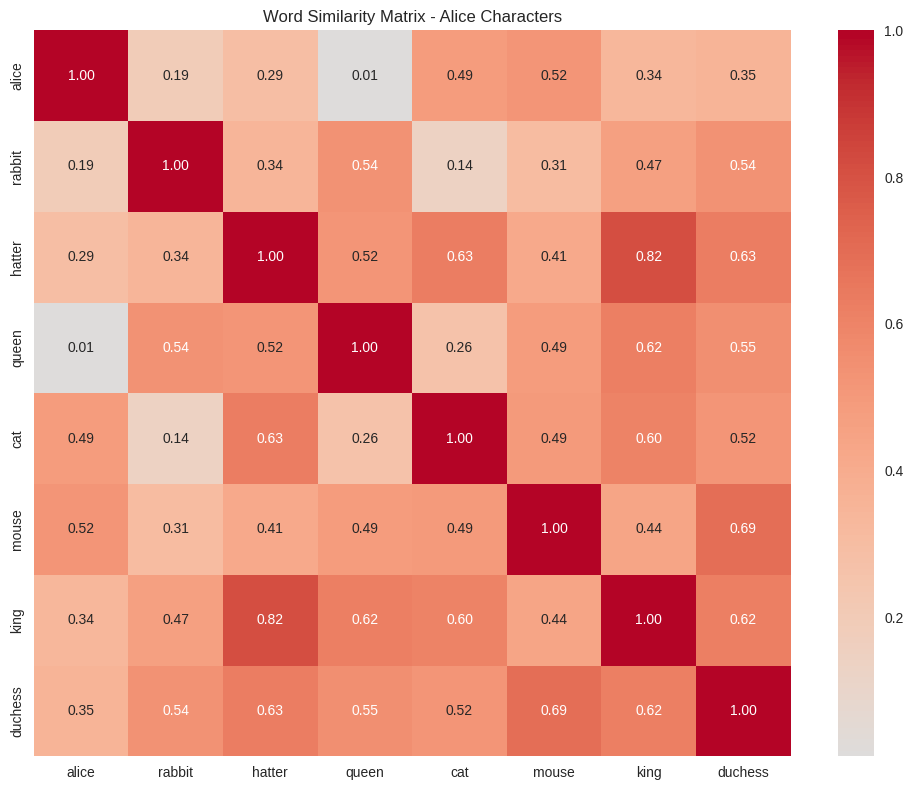

In [224]:


def visualize_word_similarities(model, words):
    """Create heatmap of word similarities"""

    # Filter words that exist in vocabulary
    vocab_words = [word for word in words if word in model.wv]

    if len(vocab_words) < 2:
        print("Not enough words in vocabulary for visualization")
        return

    # Create similarity matrix
    similarity_matrix = np.zeros((len(vocab_words), len(vocab_words)))

    for i, word1 in enumerate(vocab_words):
        for j, word2 in enumerate(vocab_words):
            if i != j:
                similarity_matrix[i][j] = model.wv.similarity(word1, word2)
            else:
                similarity_matrix[i][j] = 1.0

    # Create heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(similarity_matrix,
                xticklabels=vocab_words,
                yticklabels=vocab_words,
                annot=True,
                cmap='coolwarm',
                center=0,
                fmt='.2f')
    plt.title('Word Similarity Matrix - Alice Characters')
    plt.tight_layout()
    plt.show()

# Visualize Alice character relationships
alice_characters = ['alice', 'rabbit', 'hatter', 'queen', 'cat', 'mouse', 'king', 'duchess']
visualize_word_similarities(model, alice_characters)

#### Word Embeddings Visualization (2D)

This function takes a trained word embedding model (like Word2Vec) and shows the words in 2D space so you can see how similar words group together.

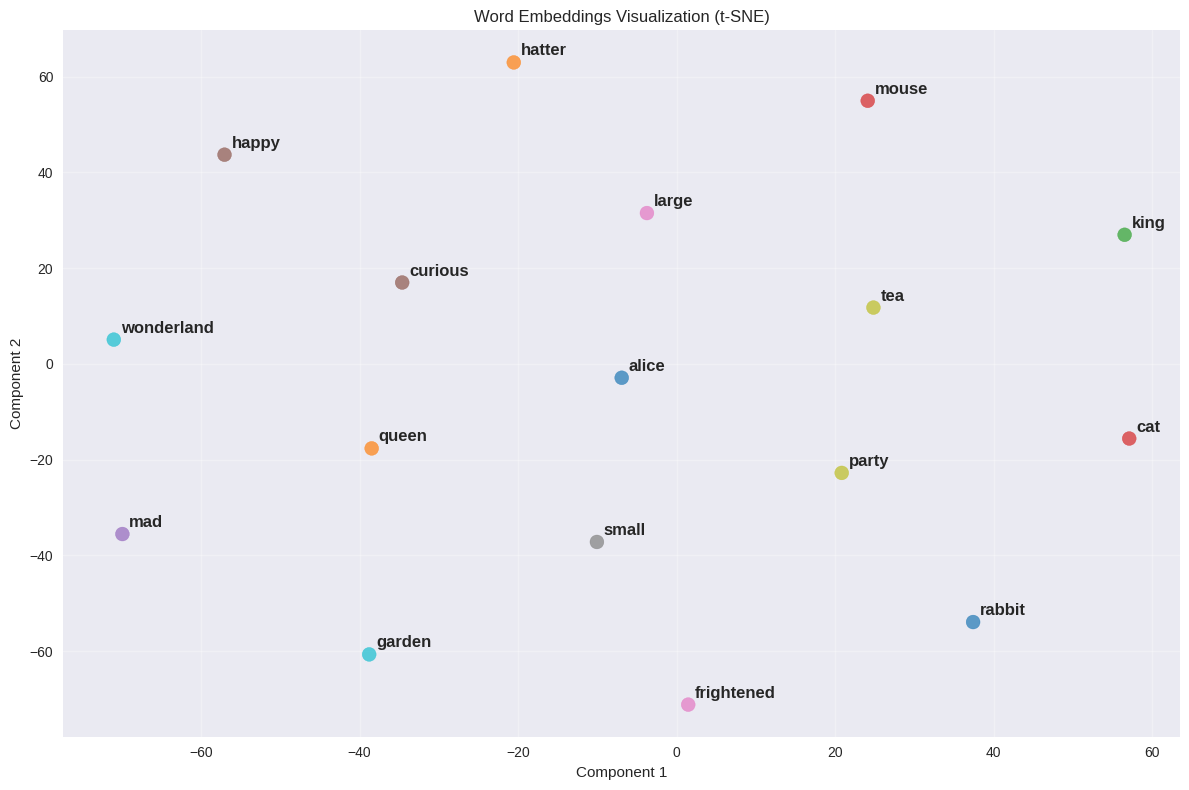

In [226]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_word_embeddings(model, words, method='tsne'):
    """Visualize word embeddings in 2D space"""

    # Filter words in vocabulary
    vocab_words = [word for word in words if word in model.wv]

    if len(vocab_words) < 3:
        print("Need at least 3 words for visualization")
        return

    # Get word vectors
    word_vectors = np.array([model.wv[word] for word in vocab_words])

    # Reduce dimensionality
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        coords = reducer.fit_transform(word_vectors)
        title = 'Word Embeddings Visualization (PCA)'
    else:
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(vocab_words)-1))
        coords = reducer.fit_transform(word_vectors)
        title = 'Word Embeddings Visualization (t-SNE)'

    # Create scatter plot
    plt.figure(figsize=(12, 8))
    scatter = plt.scatter(coords[:, 0], coords[:, 1], s=100, alpha=0.7, c=range(len(vocab_words)), cmap='tab10')

    # Add word labels
    for i, word in enumerate(vocab_words):
        plt.annotate(word, (coords[i, 0], coords[i, 1]),
                    xytext=(5, 5), textcoords='offset points',
                    fontsize=12, fontweight='bold')

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualize different word categories
all_words = ['alice', 'rabbit', 'hatter', 'queen', 'king', 'cat', 'mouse',
             'mad', 'happy', 'curious', 'frightened', 'large', 'small',
             'tea', 'party', 'garden', 'wonderland']

visualize_word_embeddings(model, all_words, method='tsne')


- Takes high-dimensional word vectors (50-300 dimensions)
- Reduces them to 2D using t-SNE or PCA
- Creates a scatter plot where similar words appear closer together
- Labels each point with the actual word

### Model Performance Visualization

This code gives a quick visual summary of what the model learned and how it’s set up.

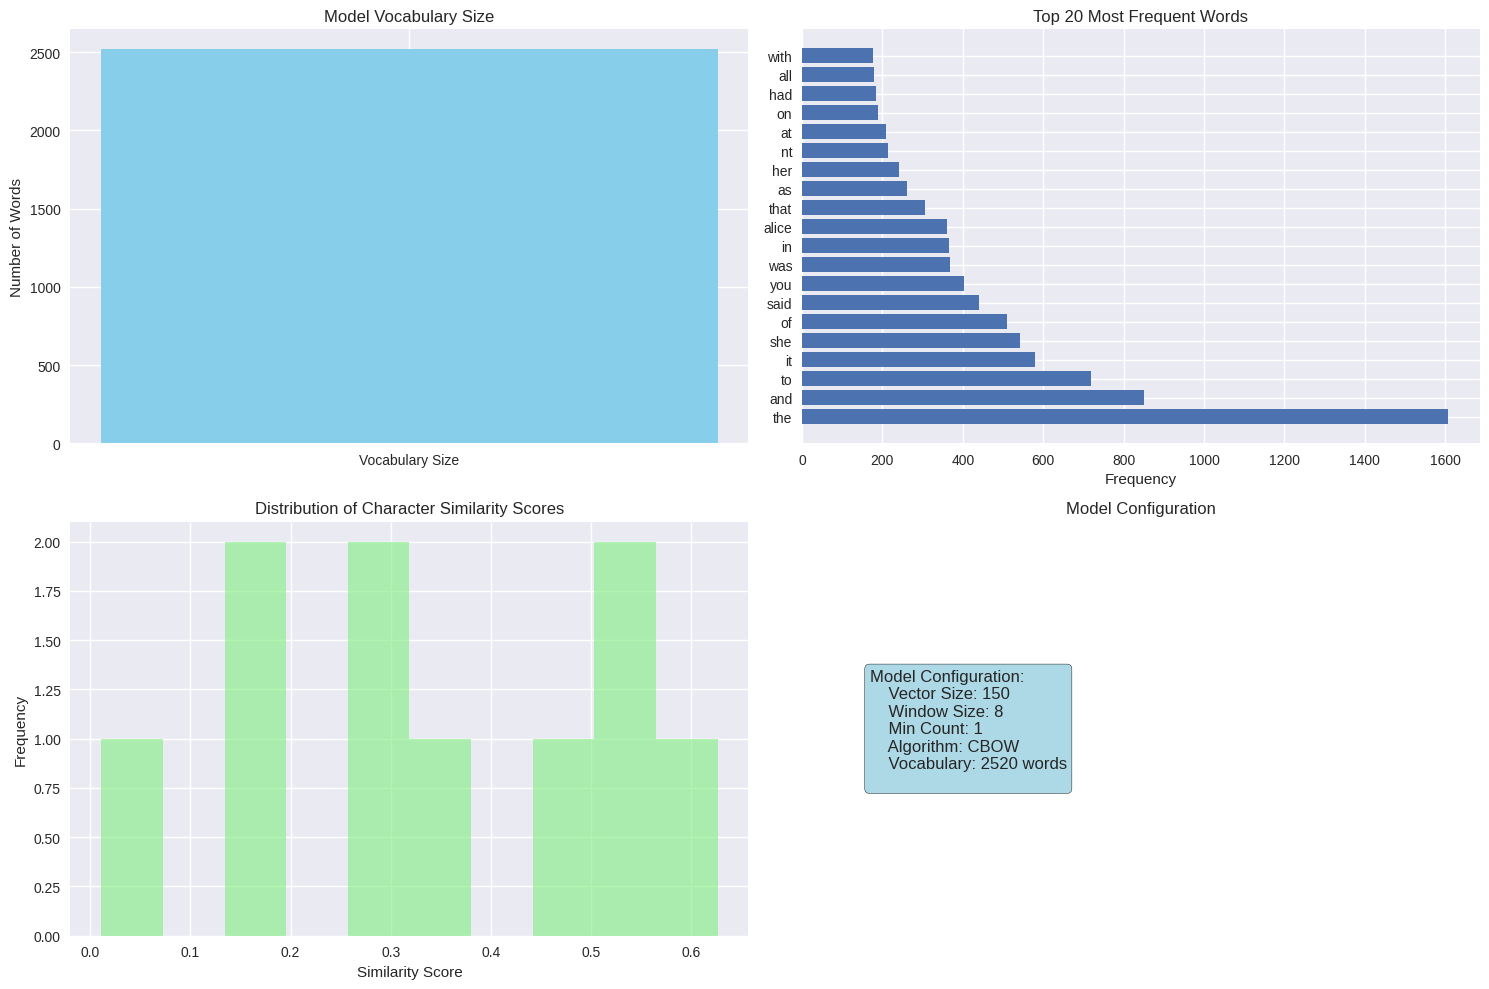

In [227]:
def plot_model_performance(model):
    """Visualize model training and performance metrics"""

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Vocabulary size and coverage
    vocab_size = len(model.wv.index_to_key)
    ax1.bar(['Vocabulary Size'], [vocab_size], color='skyblue')
    ax1.set_title('Model Vocabulary Size')
    ax1.set_ylabel('Number of Words')

    # 2. Word frequency distribution (top 20 words)
    word_freq = {}
    for sentence in processed_sentences:
        for word in sentence:
            word_freq[word] = word_freq.get(word, 0) + 1

    top_words = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)[:20]
    words, freqs = zip(*top_words)

    ax2.barh(range(len(words)), freqs)
    ax2.set_yticks(range(len(words)))
    ax2.set_yticklabels(words)
    ax2.set_title('Top 20 Most Frequent Words')
    ax2.set_xlabel('Frequency')

    # 3. Similarity score distribution for sample word pairs
    alice_chars = ['alice', 'rabbit', 'hatter', 'queen', 'cat']
    similarities = []

    for i in range(len(alice_chars)):
        for j in range(i+1, len(alice_chars)):
            if alice_chars[i] in model.wv and alice_chars[j] in model.wv:
                sim = model.wv.similarity(alice_chars[i], alice_chars[j])
                similarities.append(sim)

    ax3.hist(similarities, bins=10, alpha=0.7, color='lightgreen')
    ax3.set_title('Distribution of Character Similarity Scores')
    ax3.set_xlabel('Similarity Score')
    ax3.set_ylabel('Frequency')

    # 4. Model parameters summary
    params_text = f"""Model Configuration:
    Vector Size: {model.wv.vector_size}
    Window Size: {model.window}
    Min Count: {model.min_count}
    Algorithm: {"Skip-gram" if model.sg else "CBOW"}
    Vocabulary: {len(model.wv.index_to_key)} words
    """

    ax4.text(0.1, 0.5, params_text, fontsize=12, verticalalignment='center',
             bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)
    ax4.axis('off')
    ax4.set_title('Model Configuration')

    plt.tight_layout()
    plt.show()

# Generate comprehensive performance visualization
plot_model_performance(model)

- Total vocabulary size
- Most frequent words in the corpus
- Distribution of similarity scores between key characters
- Model configuration parameters